# Генерация имени с помощью рекуррентной нейронной сети



In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
sys.path.append("..")
import keras_utils
import tqdm_utils

1.12.0


Using TensorFlow backend.


# Загружаем данные

Набор данных содержит ~8 тыс. имен людей из разных культур, все в латинской транскрипции.


In [3]:
start_token = " "  # so that the network knows that we're generating a first token

# this is the token for padding,
# we will add fake pad token at the end of names 
# to make them of equal size for further batching
pad_token = "#"

with open("names.txt") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + name for name in names]

In [4]:
print('number of samples:', len(names))
for x in names[::1000]:
    print(x)

number of samples: 7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length: 16


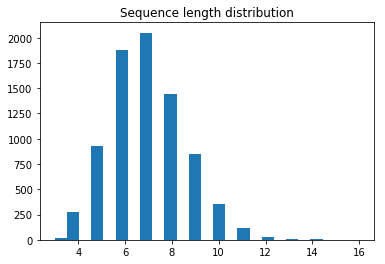

In [5]:
MAX_LENGTH = max(map(len, names))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)), bins=25);

# Обрабатываем текст

Сначала нужно собрать словарь всех уникальных токенов, т. е. уникальных символов. Затем мы можем кодировать входные данные в виде последовательности кодов символов.

In [ ]:
tokens = ### YOUR CODE HERE: all unique characters go here, padding included!

tokens = list(tokens)
n_tokens = len(tokens)
print ('n_tokens:', n_tokens)

assert 50 < n_tokens < 60

### Переводим все от символов к идентификаторам

В TensorFlow работа со строками непростая, поэтому упростим ее. Мы будем подавать в нашу рекуррентную нейронную сеть идентификаторы символов из нашего словаря.

Для создания такого словаря определим `token_to_id`

In [ ]:
token_to_id = ### YOUR CODE HERE: create a dictionary of {symbol -> its  index in tokens}

assert len(tokens) == len(token_to_id), "dictionaries must have same size"

In [ ]:
def to_matrix(names, max_len=None, pad=token_to_id[pad_token], dtype=np.int32):
    """Casts a list of names into rnn-digestable padded matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [ ]:
# Example: cast 4 random names to padded matrices (so that we can easily batch them)
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

# Строим рекуррентную нейронную сеть

Мы можем переписать рекуррентную нейронную сеть как последовательное применение полносвязного слоя ко входу $x_t$ и предыдущему состоянию РНС $h_t$.

<img src="./rnn.png" width=600>

Поскольку мы обучаем языковую модель, у нас должен быть:
* Трансформационный слой, преобразующий идентификатор символа $x_t$ в вектор.
* Выходной слой, который предсказывает вероятность следующего символа на основе $h_{t+1}$

In [7]:
# remember to reset your session if you change your graph!
s = keras_utils.reset_tf_session()

In [ ]:
import keras
from keras.layers import concatenate, Dense, Embedding

rnn_num_units = 64  # size of hidden state
embedding_size = 16  # for characters

# Let's create layers for our recurrent network
# Note: we create layers but we don't "apply" them yet (this is a "functional API" of Keras)
# Note: set the correct activation (from keras.activations) to Dense layers!

# an embedding layer that converts character ids into embeddings
embed_x = Embedding(n_tokens, embedding_size)

# a dense layer that maps input and previous state to new hidden state, [x_t,h_t]->h_t+1
get_h_next = ### YOUR CODE HERE

# a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
get_probas = ### YOUR CODE HERE 

Генерируем символа имен буква за буквой, начиная с `start_token`:

<img src="./char-nn.png" width=600>

In [ ]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces 
    probabilities for next token x_t+1 and next state h_t+1
    given current input x_t and previous state h_t.
    We'll call this method repeatedly to produce the whole sequence.
    
    You're supposed to "apply" above layers to produce new tensors.
    Follow inline instructions to complete the function.
    """
    # convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    
    # concatenate x_t embedding and previous h_t state
    x_and_h = ### YOUR CODE HERE
    
    # compute next state given x_and_h
    h_next = ### YOUR CODE HERE
    
    # get probabilities for language model P(x_next|h_next)
    output_probas = ### YOUR CODE HERE
    
    return output_probas, h_next

# Цикл РНС

Будем применять `rnn_one_step` в цикле по символами имен, чтобы получить прогнозы.

Предположим, что все имена имеют максимальную длину-16, поэтому мы можем просто перебирать их в цикле for.

In [ ]:
input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))  # batch of token ids
batch_size = tf.shape(input_sequence)[0]

predicted_probas = []
h_prev = tf.zeros([batch_size, rnn_num_units])  # initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]  # column t
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
# combine predicted_probas into [batch, time, n_tokens] tensor
predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])

# next to last token prediction is not needed
predicted_probas = predicted_probas[:, :-1, :]

# РНС: функция потерь и градиенты

Посторим матрицу предсказаний для $P (x_{next}|h)$ и соответствующих правильных ответов.

Мы будем растягивать эту матрицу в вид [None, n_tokens].

РНС может быть обучена путем минимизации кроссэнтропии между предсказанными вероятностями и этими ответами.

In [ ]:
# flatten predictions to [batch*time, n_tokens]
predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])

# flatten answers (next tokens) and one-hot encode them
answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

Обычно рекомендуется игнорировать градиенты потерь для символа заполнения. Поэтому мы не заботимся о прогнозах после того, как был предсказан pad_token. 

In [ ]:
# Define the loss as categorical cross-entropy (e.g. from keras.losses).
# Mind that predictions are probabilities and NOT logits!
# Remember to apply tf.reduce_mean to get a scalar loss!
loss = ### YOUR CODE HERE

optimize = tf.train.AdamOptimizer().minimize(loss)

# РНС: обучение

In [ ]:
from IPython.display import clear_output
from random import sample

s.run(tf.global_variables_initializer())

batch_size = 32
history = []

for i in range(1000):
    batch = to_matrix(sample(names, batch_size), max_len=MAX_LENGTH)
    loss_i, _ = s.run([loss, optimize], {input_sequence: batch})
    
    history.append(loss_i)
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge"

# РНС: генерация

После того, как мы немного обучили нашу сеть, давайте перейдем к фактической генерации имен. Все, что нам нужно-это функция `rnn_one_step'.

In [ ]:
x_t = tf.placeholder(tf.int32, (1,))
h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32))  # we will update hidden state in this variable

# For sampling we need to define `rnn_one_step` tensors only once in our graph.
# We reuse all parameters thanks to functional API usage.
# Then we can feed appropriate tensor values using feed_dict in a loop.
# Note how different it is from training stage, where we had to unroll the whole sequence for backprop.
next_probs, next_h = rnn_one_step(x_t, h_t)

In [ ]:
def generate_sample(seed_phrase=start_token, max_length=MAX_LENGTH):
    '''
    This function generates text given a `seed_phrase` as a seed.
    Remember to include start_token in seed phrase!
    Parameter `max_length` is used to set the number of characters in prediction.
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t, h_t.initial_value))
    
    # feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t, next_h), {x_t: [ix]})
    
    # start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != pad_token])

In [ ]:
# without prefix
for _ in range(10):
    print(generate_sample())

In [ ]:
# with prefix conditioning
for _ in range(10):
    print(generate_sample(' Trump'))

# Try it out!

__Disclaimer:__ This part of assignment is entirely optional. You won't receive bonus points for it. However, it's a fun thing to do. Please share your results on course forums.

You've just implemented a recurrent language model that can be tasked with generating any kind of sequence, so there's plenty of data you can try it on:

* Novels/poems/songs of your favorite author
* News titles/clickbait titles
* Source code of Linux or Tensorflow
* Molecules in [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) format
* Melody in notes/chords format
* IKEA catalog titles
* Pokemon names
* Cards from Magic, the Gathering / Hearthstone

If you're willing to give it a try, here's what you wanna look at:
* Current data format is a sequence of lines, so a novel can be formatted as a list of sentences. Alternatively, you can change data preprocessing altogether.
* While some datasets are readily available, others can only be scraped from the web. Try `Selenium` or `Scrapy` for that.
* Make sure MAX_LENGTH is adjusted for longer datasets. There's also a bonus section about dynamic RNNs at the bottom.
* More complex tasks require larger RNN architecture, try more neurons or several layers. It would also require more training iterations.
* Long-term dependencies in music, novels or molecules are better handled with LSTM or GRU

__Good hunting!__

# Динамические РНС

Помимо Keras, есть также TensorFlow API для рекуррентных нейронных сетей. В его основе лежит функция символьного цикла (ака [tf.scan](https://www.tensorflow.org/api_docs/python/tf/scan)).

РНС цикл, который мы реализовали для обучения, может быть заменен на однуTensorFlow инструкцию: [tf.nn.dynamic_rnn](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn). Этот интерфейс учитывает динамическую длину последовательности и идет с некоторыми предобученными архитектурами.

[tf.nn.rnn_cell.BasicRNNCell](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/BasicRNNCell).

In [ ]:
class CustomRNN(tf.nn.rnn_cell.BasicRNNCell):
    def call(self, input, state):
        # from docs:
        # Returns:
        # Output: A 2-D tensor with shape [batch_size, self.output_size].
        # New state: Either a single 2-D tensor, or a tuple of tensors matching the arity and shapes of state.
        return rnn_one_step(input[:, 0], state)
    
    @property
    def output_size(self):
        return n_tokens
    
cell = CustomRNN(rnn_num_units)

input_sequence = tf.placeholder(tf.int32, (None, None))
    
predicted_probas, last_state = tf.nn.dynamic_rnn(cell, input_sequence[:, :, None], dtype=tf.float32)

print('LSTM outputs for each step [batch,time,n_tokens]:')
print(predicted_probas.eval({input_sequence: to_matrix(names[:10], max_len=50)}).shape)

Обратите внимание, что мы никогда не использовали MAX_LENGTH в коде выше: TF будет перебирать столько временных шагов, сколько вы ему дали.

Можно также использовать любую предварительно реализованную ячейку РНС:

In [ ]:
for obj in dir(tf.nn.rnn_cell) + dir(tf.contrib.rnn):
    if obj.endswith('Cell'):
        print(obj, end="\t")

In [ ]:
input_sequence = tf.placeholder(tf.int32, (None, None))

inputs_embedded = embed_x(input_sequence)

# standard cell returns hidden state as output!
cell = tf.nn.rnn_cell.LSTMCell(rnn_num_units)

state_sequence, last_state = tf.nn.dynamic_rnn(cell, inputs_embedded, dtype=tf.float32)

s.run(tf.global_variables_initializer())

print('LSTM hidden state for each step [batch,time,rnn_num_units]:')
print(state_sequence.eval({input_sequence: to_matrix(names[:10], max_len=50)}).shape)